# SIS with external infection, integrated over all initial conditions

This time integrate over all initial conditions


In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import linalg
from scipy.linalg import expm
from tqdm import tqdm

Code snippet to solve the stochastic SIS model with external forcing with rates

$$
X \rightarrow X+1 \text{ at rate } ((\beta X / N) + \epsilon)(N-X) \text{ ,} \qquad
X \rightarrow X-1 \text{ at rate } \gamma X \text{ .}
$$

We will use matrix exponentiation to look at total variation distance

In [4]:
# Define the rates of events

def rplus(X,N,beta,epsilon):
    return ((beta*X/N) + epsilon)*(N-X)

def rminus(X,N,gamma):
    return gamma*X

rates = [rplus, rminus]

In [5]:
N = 500 # Population size
beta = 2 # Allow for invasion
gamma = 1
epsilon = 0.01

In [6]:
Xran = np.arange(0,N+1)
M = - np.diag(rplus(Xran,N,beta,epsilon) + rminus(Xran,N,gamma))
M += np.diag(rminus(Xran[1:],N,gamma),1)
M += np.diag(rplus(Xran[:-1],N,beta,epsilon),-1)

We now want to calculate $\boldsymbol{\pi}$, the stationary distribution.

Note that the generator matrix, $\boldsymbol{M}$ has columns that sum to 0 and so a simple solve operation will not work, instead we create a new matrix $\boldsymbol{H}$ equal to $\boldsymbol{M}$ but with first row all equal to 1 to impose that the solution should be a probability vector.

In [8]:
H = np.vstack(
    [
    np.atleast_2d(np.ones(N+1)),
    M[1:,:]
    ]
)
b = np.zeros(N+1)
b[0] = 1
pi = linalg.solve(H,b)

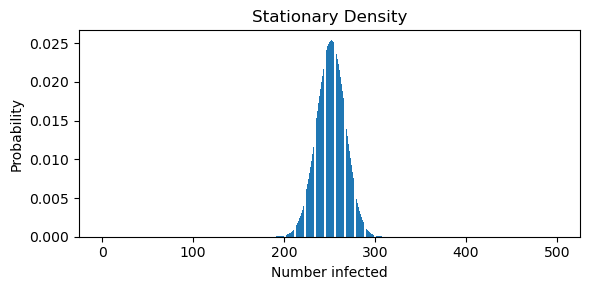

In [9]:
plt.figure(figsize=(6,3))
plt.bar(np.arange(0,N+1),pi)
plt.xlabel('Number infected')
plt.ylabel('Probability')
plt.title('Stationary Density')
plt.tight_layout()

In [10]:
Ii = np.identity(N+1)

In [11]:
deltat = 0.01
tmax = 12
tsteps = int((tmax/deltat) + 1)
pstore = np.zeros([tsteps,N+1,N+1])
pstore[0,:,:] = Ii.copy()

In [12]:
# Solve using implicit Euler to capture all initial conditions at once
for i in tqdm(range(1,tsteps)):
    pstore[i,:,:] = linalg.solve(Ii-M*deltat,pstore[i-1,:,:])

100%|██████████████████████████████████████| 1200/1200 [00:09<00:00, 131.31it/s]


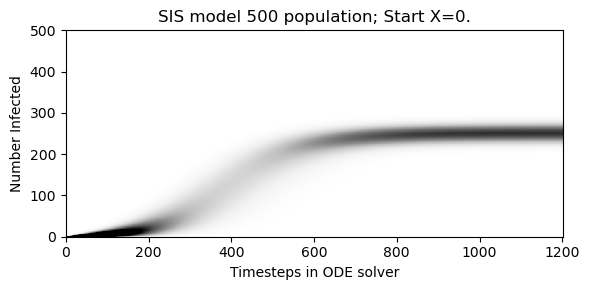

In [13]:
fig = plt.figure(figsize=(6,3))
plt.pcolor(
    pstore[:,:,0].T,
    cmap = 'Greys',
    vmin = 0.0,
    vmax = 0.03,    
)
plt.xlim([0,tsteps])
plt.ylim([0,N])
plt.xlabel('Timesteps in ODE solver')
plt.ylabel('Number Infected')
plt.title('SIS model ' + str(N) + ' population; Start X=0.')
plt.tight_layout()

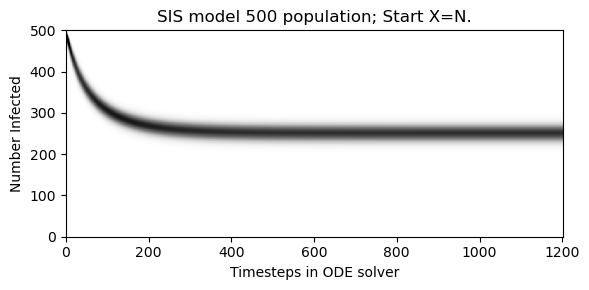

In [14]:
fig = plt.figure(figsize=(6,3))
plt.pcolor(
    pstore[:,:,-1].T,
    cmap = 'Greys',
    vmin = 0.0,
    vmax = 0.03,    
)
plt.xlim([0,tsteps])
plt.ylim([0,N])
plt.xlabel('Timesteps in ODE solver')
plt.ylabel('Number Infected')
plt.title('SIS model ' + str(N) + ' population; Start X=N.')
plt.tight_layout()

For a discrete probability distribution, we have the standard result that
$$
D_{\mathrm{TV}} = \frac{1}{2} \sum_i |p_i(t) - \pi_i|
$$
We now want to take the maximum of this over initial conditions

In [16]:
pitensor = np.zeros([tsteps,N+1,N+1]) # Indices are time, state, initial condition
for i in range(0,tsteps):
    for j in range(0,N+1):
        pitensor[i,:,j] = pi
tv_dist = (1/2)*np.sum(np.abs(pstore - pitensor),1)

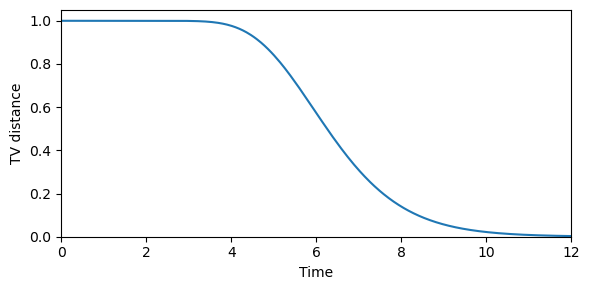

In [17]:
fig = plt.figure(figsize=(6,3))
plt.plot(np.arange(0,tmax+deltat,deltat),np.max(tv_dist,axis=1)) # Indices are time, initial condition
plt.xlabel('Time')
plt.ylim([0,1.05])
plt.xlim([0,tmax])
plt.ylabel('TV distance')
plt.tight_layout()